In [1]:
import keras
import nb_utils
import numpy as np

Using TensorFlow backend.


In [2]:
import json
squad_training_json = json.load(
    open(nb_utils.download('https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json'))
)

squad_test_json = json.load(
    open(nb_utils.download('https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json'))
)

## Converting our data

The squad training data is structured as a list of paragraphs, each with an associated set of questions.  Let's preprocess this a bit before we continue

In [3]:
squad_training_json['data'][1]['paragraphs'][0]

{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
   'id': '56be85543aeaaa14008c9063',
   'question': 'When did Beyonce start becoming popular?'},
  {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
   'id': '56be85543aeaaa14008c9065',
   'ques

In [4]:
from keras.preprocessing.text import Tokenizer

MAX_VOCAB_SIZE = 250000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

In [5]:
all_text = []

for article in squad_training_json['data'] + squad_test_json['data']:
    for p in article['paragraphs']:
        all_text.append(p['context'])
        for qa in p['qas']:
            all_text.append(qa['question'])
            
tokenizer.fit_on_texts(all_text)
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)

In [6]:
def prep_data(dataset):
    question_tokens = []
    answer_locations = []
    context_tokens = []

    for article in dataset['data']:
        for p in article['paragraphs']:
            ct = tokenizer.texts_to_sequences([p['context']])[0]

            for qa in p['qas']:
                qt = tokenizer.texts_to_sequences([qa['question']])[0]
                at = tokenizer.texts_to_sequences([qa['answers'][0]['text']])[0]
                for j in range(len(ct) - len(at)):
                    if ct[j:j+len(at)] == at:
                        question_tokens.append(qt)
                        answer_locations.append((j, j + len(at)))
                        context_tokens.append(ct)
                        break
    
    return {
        'q': question_tokens,
        'a': answer_locations,
        'ctx': context_tokens
    }

squad_train = prep_data(squad_training_json)
squad_test = prep_data(squad_test_json)

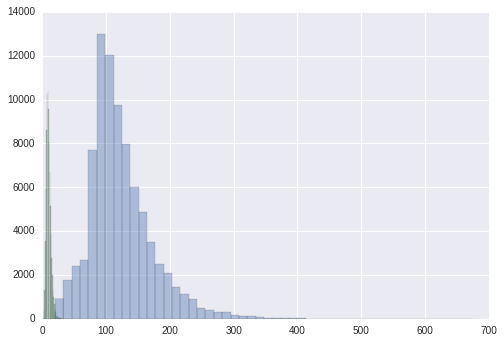

In [7]:
%matplotlib inline
import seaborn
[
    seaborn.distplot([len(s) for s in squad_train['ctx']], kde=False),
    seaborn.distplot([len(s) for s in squad_train['q']], kde=False),
]

# Pretrained word vectors

We don't have a lot of training data for the Squad dataset, so instead of training our word vectors from scratch, let's start with pre-trained vectors.  This will allow our network to focus on learning parameters that optimize finding the right words in our text.

In [51]:
import numpy as np
import tqdm

EMBEDDING_SIZE = 50
word_vectors = np.zeros((vocab_size, EMBEDDING_SIZE))

with open('/home/power/Downloads/glove.6B.%dd.txt' % EMBEDDING_SIZE, 'r') as f:
    for line in f:
        word, ary = line.split(' ', 1)
        if word in tokenizer.word_index:
            word_vectors[tokenizer.word_index[word]] = np.fromstring(ary, sep=' ', dtype=np.float32)

In [89]:
def sim(A, b):
    am = 1e-9 + np.sum(A * A, axis=1)
    bm = np.dot(b, b)
    sim = np.dot(A, b) / (np.sqrt(am) * np.sqrt(bm))
    sim_idx = np.argsort(sim)
    return zip(sim_idx[-10:], sim[sim_idx[-10:]])

idx_to_word = {v:k for k,v in tokenizer.word_index.items()}
idx_to_word[0] = 'n/a'
for idx, dist in sim(word_vectors, word_vectors[tokenizer.word_index['beyonce']]):
    print(idx_to_word[idx], dist)

foxx 0.708784659092
aretha 0.711284679727
stevie 0.716988531102
kanye 0.73881587196
knowles 0.742291995652
timberlake 0.768287273499
beyoncé 0.779903867891
blige 0.782109394434
mariah 0.802994181335
beyonce 0.999999999982


In [90]:
import random
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

def training_generator(dataset, bs):
    while True:
        batch_q = []
        batch_c = []
        start_idx = []
        end_idx = []
        
        q, a, ctx = dataset['q'], dataset['a'], dataset['ctx']

        idx = np.random.randint(0, len(ctx) - 1, size=bs)
        for i in idx:
            batch_q.append(q[i])
            batch_c.append(ctx[i])
            start_idx.append(a[i][0])
            end_idx.append(a[i][1])
        
        batch_q = pad_sequences(batch_q)
        batch_c = pad_sequences(batch_c)
        onehot_start = np.zeros_like(batch_c)
        onehot_end = np.zeros_like(batch_c)
        onehot_start[np.arange(len(start_idx)), start_idx] = 1
        onehot_end[np.arange(len(start_idx)), end_idx] = 1
        
        yield ({
            'question': batch_q,
            'context': batch_c,
        }, {
            'start_idx': onehot_start,
            'end_idx': onehot_end,
        })

        
tg = training_generator(squad_train, 32)
for i in range(10):
    x, y = next(tg)

s_idx = np.nonzero(y['start_idx'])[1][0]
e_idx = np.nonzero(y['end_idx'])[1][0]

{ 
    'ctx': [idx_to_word[w] for w in x['context'][0]],
    'q': [idx_to_word[w] for w in x['question'][0]],
    'a': [idx_to_word[w] for w in x['context'][0][s_idx:e_idx]]
}

{'a': ['n/a', 'n/a'],
 'ctx': ['n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',
  'n/a',

In [109]:
import tensorflow as tf
from keras.layers.merge import concatenate
from keras import layers, models
from keras.layers import Bidirectional, LSTM
import keras.backend as K

HIDDEN_SIZE = 50
# l2 = keras.regularizers.l2(l=0.001)


# Keras/Tensorflow doesn't have a builtin for outer products.  We
# can abuse how broadcasting works to accomplish it, by adding 
# empty extra dimensions in the right places.
def matrix_attention(inputs):
    x, y = inputs
    outer_product = K.batch_dot(x, y, axes=(2,2))
    return outer_product

def context2query(inputs):
    question, context, op = inputs
    e = K.exp(op - K.max(op, axis=2, keepdims=True))
    s = 1e-4 + K.sum(op, axis=2, keepdims=True)
    softmax = e / s

    question = K.expand_dims(question, axis=2)
    attention = K.expand_dims(softmax, axis=-1) * question
    return K.sum(attention, axis=1)

def query2context(inputs):
    question, context, op = inputs
    attention = K.softmax(K.max(op, axis=1))
    return context * K.expand_dims(attention, axis=-1)

def bilstm(*args, **kw):
#         kw['kernel_regularizer'] = l2
#         kw['dropout'] = 0.2
    if 'name' in kw:
        name = kw['name']
        del kw['name']
    else:
        name = None
    return Bidirectional(LSTM(*args, **kw), merge_mode='concat', name=name)

def flat_softmax(inputs):
    return K.softmax(K.batch_flatten(inputs))


def softsel(inputs):
    sel, mat = inputs
    orig_shape = K.shape(mat)
    mat = K.sum(mat * sel, axis=-1)
    mat = K.expand_dims(mat, 1)
    mat = K.expand_dims(mat, 1)
    return K.reshape(mat, orig_shape)

def model():
    question = layers.Input(name='question', dtype='int32', shape=(None,))
    context = layers.Input(name='context', dtype='int32', shape=(None,))
    
    embedding = layers.Embedding(
        mask_zero=True,
        input_dim=vocab_size,
        output_dim=EMBEDDING_SIZE,
        weights=[word_vectors],
        trainable=False,
    )

    encoded_question = embedding(question)
    encoded_context = embedding(context)
    
    encoded_question = bilstm(encoded_question)
    encoded_context = bilstm(encoded_context)

    matrix_att = layers.Lambda(matrix_attention, name='att')([encoded_question, encoded_context])
    c2q = layers.Lambda(context2query, name='c2q')([encoded_question, encoded_context, matrix_att])
    q2c = layers.Lambda(query2context, name='q2c')([encoded_question, encoded_context, matrix_att])
    G = concatenate([encoded_context, 
                      c2q, 
                      layers.Multiply(name='sel_c2q')([c2q, encoded_context]),
                      layers.Multiply(name='sel_q2c')([q2c, encoded_context]),
                     ])

    M = bilstm(units=HIDDEN_SIZE, return_sequences=True)(G)
    
    idx_input = concatenate([M, G], name='idx_input')

    start_idx = bilstm(units=HIDDEN_SIZE, return_sequences=True, name='start_idx_lstm')(idx_input)
    start_idx = layers.TimeDistributed(layers.Dense(units=1))(start_idx)
    start_idx = layers.Lambda(flat_softmax, name='start_idx')(start_idx)
    
    end_idx = bilstm(units=HIDDEN_SIZE, return_sequences=True, name='end_idx_lstm')(idx_input)
    end_idx = layers.TimeDistributed(layers.Dense(units=1))(end_idx)
    end_idx = layers.Lambda(flat_softmax, name='end_idx')(end_idx)
    
    model = models.Model(inputs=[question, context],
                        outputs=[start_idx, end_idx])
    
    return model
    

import tensorflow as tf
m = model()
m.compile(
    metrics=['accuracy'],
    optimizer='adam',
    loss={'start_idx': 'categorical_crossentropy', 'end_idx': 'categorical_crossentropy'},
)

m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
context (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
question (InputLayer)            (None, None)          0                                            
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, None, 50)      4884450     question[0][0]                   
                                                                   context[0][0]                    
____________________________________________________________________________________________________
att (Lambda)                     (None, None, None)    0           embedding_8[0][0]       

In [110]:
x, y = next(training_generator(squad_train, bs=1))
m.predict(x)

[array([[ 0.01483208,  0.01383604,  0.01238179,  0.01164735,  0.01106084,
          0.0100648 ,  0.01262134,  0.0130599 ,  0.01286688,  0.0112294 ,
          0.01096907,  0.01059796,  0.01095027,  0.00982713,  0.00954198,
          0.01114662,  0.01279745,  0.01445914,  0.01583774,  0.0157361 ,
          0.01398905,  0.01265113,  0.0119996 ,  0.01440606,  0.01520634,
          0.01457738,  0.01396388,  0.01262292,  0.00996734,  0.01014959,
          0.00827183,  0.00917331,  0.00944578,  0.0095413 ,  0.00916815,
          0.01009691,  0.01315981,  0.01458935,  0.01604154,  0.015453  ,
          0.0150847 ,  0.01566288,  0.01474436,  0.01580637,  0.01444684,
          0.01479789,  0.01336432,  0.01225285,  0.01193167,  0.01166679,
          0.01250943,  0.01349258,  0.01302106,  0.01290794,  0.01395621,
          0.01294354,  0.01181662,  0.01217321,  0.01141638,  0.01217545,
          0.01200444,  0.01227443,  0.01378706,  0.01424229,  0.01408861,
          0.01285938,  0.01354672,  0.

In [112]:
m.fit_generator(training_generator(squad_train, bs=8), steps_per_epoch=10000, epochs=10)

Epoch 1/10
    7/10000 [..............................] - ETA: 37410s - loss: 10.1994 - start_idx_loss: 5.1117 - end_idx_loss: 5.0877 - start_idx_acc: 0.0000e+00 - end_idx_acc: 0.0000e+00

KeyboardInterrupt: 